## Bollinger Band
---

In [1]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr

In [46]:
df = fdr.DataReader('SPY')

In [47]:
df.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1993-02-01,44.25,43.97,44.25,43.97,480500.0,0.0071
1993-02-02,44.34,44.22,44.38,44.12,201300.0,0.0020
1993-02-03,44.81,44.41,44.84,44.38,529400.0,0.0106
1993-02-04,45.00,44.97,45.09,44.88,531500.0,0.0042
1993-02-05,44.97,44.97,45.06,44.72,492100.0,-0.0007


In [48]:
# index reset
df.reset_index(inplace=True)

In [49]:
df['CODE'] = 'SPY'
price_df = df.loc[:,['Date','Close']].copy()
price_df.head()

,Date,Close
0,1993-02-01,44.25
1,1993-02-02,44.34
2,1993-02-03,44.81
3,1993-02-04,45.00
4,1993-02-05,44.97


In [50]:
price_df.set_index(['Date'], inplace=True)
price_df.head()

,Close
Date,
1993-02-01,44.25
1993-02-02,44.34
1993-02-03,44.81
1993-02-04,45.00
1993-02-05,44.97



- Upper: center Band + 2 * 20일 MA 표준 편차 
- Center: 20일 이동 평균선 
- Lower: center Band - 2 * 20일 MA 표준 편차

In [51]:
# ['center']: 20 Days MA column
price_df['center'] = price_df['Close'].rolling(20).mean()
price_df.iloc[18:25]

,Close,center
Date,,
1993-02-26,44.41,NaN
1993-03-01,44.28,44.2910
1993-03-02,44.94,44.3255
1993-03-03,45.12,44.3645
1993-03-04,44.88,44.3680
1993-03-05,44.75,44.3555
1993-03-08,45.75,44.3945


In [52]:
# upper Bollinger Band(+ 2)
price_df['ub'] = price_df['center'] + 2 * price_df['Close'].rolling(20).std()

In [53]:
price_df.iloc[18:25]

,Close,center,ub
Date,,,
1993-02-26,44.41,NaN,NaN
1993-03-01,44.28,44.2910,45.409587
1993-03-02,44.94,44.3255,45.480726
1993-03-03,45.12,44.3645,45.573214
1993-03-04,44.88,44.3680,45.582537
1993-03-05,44.75,44.3555,45.547588
1993-03-08,45.75,44.3945,45.715321


In [54]:
# lower Bollinger Band
price_df['lb'] = price_df['center'] - 2 * price_df['Close'].rolling(20).std()
price_df.iloc[18:25]

,Close,center,ub,lb
Date,,,,
1993-02-26,44.41,NaN,NaN,NaN
1993-03-01,44.28,44.2910,45.409587,43.172413
1993-03-02,44.94,44.3255,45.480726,43.170274
1993-03-03,45.12,44.3645,45.573214,43.155786
1993-03-04,44.88,44.3680,45.582537,43.153463
1993-03-05,44.75,44.3555,45.547588,43.163412
1993-03-08,45.75,44.3945,45.715321,43.073679


In [55]:
# 이동평균선 기간 및 표준 편차 값 설정
n = 20
sigma = 2

In [56]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Close'].rolling(n).mean()
    bb['ub'] = bb['center'] + sigma * price_df['Close'].rolling(20).std()
    bb['lb'] = bb['center'] - sigma * price_df['Close'].rolling(20).std()
    return bb

In [57]:
bollinger = bollinger_band(price_df, n, sigma)

In [58]:
bollinger.iloc[18:25]

,Close,center,ub,lb
Date,,,,
1993-02-26,44.41,NaN,NaN,NaN
1993-03-01,44.28,44.2910,45.409587,43.172413
1993-03-02,44.94,44.3255,45.480726,43.170274
1993-03-03,45.12,44.3645,45.573214,43.155786
1993-03-04,44.88,44.3680,45.582537,43.153463
1993-03-05,44.75,44.3555,45.547588,43.163412
1993-03-08,45.75,44.3945,45.715321,43.073679


In [59]:
base_date = '2021-01-01'

In [60]:
sample = bollinger.loc[base_date:]
sample.head()

,Close,center,ub,lb
Date,,,,
2021-01-04,368.79,369.2395,373.928603,364.550397
2021-01-05,371.33,369.3135,374.089084,364.537916
2021-01-06,373.55,369.5365,374.671168,364.401832
2021-01-07,379.10,369.9830,376.668488,363.297512
2021-01-08,381.26,370.7035,378.902055,362.504945


In [61]:
book = sample[['Close']].copy()
book['trade'] = '' # 거래내역
book.head()

,Close,trade
Date,,
2021-01-04,368.79,
2021-01-05,371.33,
2021-01-06,373.55,
2021-01-07,379.10,
2021-01-08,381.26,


- 볼린저 밴드를 이용해서 과매수/과매도 구간을 포착하는 지표로 활용
- 단기 매매에 효과적

In [67]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Close'] and sample.loc[i, 'Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [68]:
book = tradings(sample,book)

In [69]:
book.tail(10)

,Close,trade,return,acc return
Date,,,,
2021-07-26,441.02,,1.0,1.154065
2021-07-27,439.01,,1.0,1.154065
2021-07-28,438.83,,1.0,1.154065
2021-07-29,440.65,,1.0,1.154065
2021-07-30,438.51,,1.0,1.154065
2021-08-02,437.59,,1.0,1.154065
2021-08-03,441.15,,1.0,1.154065
2021-08-04,438.98,,1.0,1.154065
2021-08-05,441.76,,1.0,1.154065


- 전체 수익률 계산 함수
- 날짜 별 매수 신호가 있을때 Long 진입
- 이후 Long 포지션의 청산 조건 확인 후 수익률 계산
- 포지션이 정리 되면 매수, 매도금액을 저장하는 변수 초기화

In [73]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [74]:
print(returns(book))

진입일 :  2021-03-04 00:00:00 long 진입가격 :  376.7
청산일 :  2021-04-05 00:00:00 long 진입가격 :  376.7  |  long 청산가격 :  406.36  | return: 1.0787
진입일 :  2021-05-12 00:00:00 long 진입가격 :  405.41
청산일 :  2021-07-02 00:00:00 long 진입가격 :  405.41  |  long 청산가격 :  433.72  | return: 1.0698
Accunulated return : 1.1541
1.1541


## Regression to mean(BackTesting)
---
- 평균 회귀 전략 확인

In [75]:
import matplotlib.pylab as plt

<AxesSubplot:xlabel='Date'>

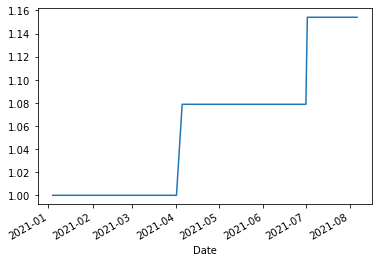

In [77]:
book['acc return'].plot()

In [78]:
book.tail()

,Close,trade,return,acc return
Date,,,,
2021-08-02,437.59,,1.0,1.154065
2021-08-03,441.15,,1.0,1.154065
2021-08-04,438.98,,1.0,1.154065
2021-08-05,441.76,,1.0,1.154065
2021-08-06,442.49,,1.0,1.154065
